In [86]:
### Import the required libraries
import numpy as np
import matplotlib.pyplot as plt 
import xarray as xr

import warnings

warnings.simplefilter("ignore")

import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from sklearn.utils import shuffle
import tensorflow.keras.backend as kbackend
import tensorflow.keras.models
from keras.utils import np_utils
from keras.regularizers import l2

tf.compat.v1.disable_eager_execution()

import innvestigate
import innvestigate.utils as iutils

In [87]:
def basal_topology_func(x):
    b = 1.0 - 0.1*x
    return b

def solution(nx, nt, L, T, M, basal_topology_func):

    if len(M) != nx + 1:
        raise ValueError('M specified but len(M) != nx + 1')
        
    dx = L/nx
    dt = T/nt
    x = np.linspace(0,L,nx+1)
    t = np.linspace(0,T,nt+1)

    b = basal_topology_func(x)

    A = 1e-16
    rho = 920.0
    g = 9.2 
    n = 3

    C = 2*A/(n+2) * (rho*g)**n * (1e3)**n

    h = np.zeros((nx+1,nt+1))
    H = np.zeros((nx+1,nt+1))
    h[:,0] = b
    h[0,:] = b[0]
    h[-1,:] = b[-1]

    H[:,0] = h[:,0] - b
    H[0,:] = h[0,:] - b[0]
    H[-1,:] = h[-1,:] - b[-1]

    for i in range(1,len(t)):

        D = C *((H[1:,i-1]+H[:nx,i-1])/2.0)**(n+2) * ((h[1:,i-1] - h[:nx,i-1])/dx)**(n-1)

        phi = -D*(h[1:,i-1]-h[:nx,i-1])/dx

        h[1:nx,i] = h[1:nx,i-1] + M[1:nx]*dt - dt/dx * (phi[1:]-phi[:nx-1])
        h[1:nx,i] = (h[1:nx,i] < b[1:nx]) * b[1:nx] + (h[1:nx,i] >= b[1:nx]) * h[1:nx,i]
        H[:,i] = np.maximum(h[:,i] - b, 0.)

        if not np.any(H[:,i]>=0.0):
            raise Exception("Something went wrong.")
            
    Volume = np.sum(H)*dx
    
    return H[int(nx/2),-1], h[int(nx/2),-1], Volume

In [3]:
L = 30.
T = 10.
nx = 300
nt = 12000
samples = 1000

M_samples = 0.01*np.random.rand(samples, nx+1)
H_samples = np.zeros((samples,1), dtype = np.float64)
Volume_samples = np.zeros((samples,1), dtype = np.float64)

for sample in range(samples):
    if (sample+1) % 10 == 0:
        print(f"Sample #{sample+1}")
    H_samples[sample], _, Volume_samples[sample] = solution(nx, nt, L, T, M_samples[sample], basal_topology_func)

Sample #10
Sample #20
Sample #30
Sample #40
Sample #50
Sample #60
Sample #70
Sample #80
Sample #90
Sample #100
Sample #110
Sample #120
Sample #130
Sample #140
Sample #150
Sample #160
Sample #170
Sample #180
Sample #190
Sample #200
Sample #210
Sample #220
Sample #230
Sample #240
Sample #250
Sample #260
Sample #270
Sample #280
Sample #290
Sample #300
Sample #310
Sample #320
Sample #330
Sample #340
Sample #350
Sample #360
Sample #370
Sample #380
Sample #390
Sample #400
Sample #410
Sample #420
Sample #430
Sample #440
Sample #450
Sample #460
Sample #470
Sample #480
Sample #490
Sample #500
Sample #510
Sample #520
Sample #530
Sample #540
Sample #550
Sample #560
Sample #570
Sample #580
Sample #590
Sample #600
Sample #610
Sample #620
Sample #630
Sample #640
Sample #650
Sample #660
Sample #670
Sample #680
Sample #690
Sample #700
Sample #710
Sample #720
Sample #730
Sample #740
Sample #750
Sample #760
Sample #770
Sample #780
Sample #790
Sample #800
Sample #810
Sample #820
Sample #830
Sample #840
S

In [88]:
keras.backend.clear_session()

inputs = Input(shape=(nx+1,))
dense1 = Dense(10, activation='relu')
dense2 = Dense(1, activation='linear', use_bias=False)

x = dense1(inputs)
x = dense2(x)

model = keras.Model(inputs=inputs, outputs=x) 

mod_h5 = 'model.h5'

checkpoint = ModelCheckpoint(mod_h5, monitor='val_loss',
                             verbose=1,save_best_only=True)
        
callbacks = [checkpoint]
model.compile(optimizer='adam',
            loss='mse', metrics=['mae'])

fit = model.fit(M_samples, H_samples,
            batch_size=10,
            epochs=1000, 
            shuffle=True,
            validation_split = 0.2, 
            callbacks=callbacks)

Train on 800 samples, validate on 200 samples
Epoch 1/1000
400/800 [==============>...............] - ETA: 0s - loss: 9.6949e-04 - mae: 0.0245

2023-06-27 12:58:11.858809: W tensorflow/c/c_api.cc:291] Operation '{name:'training/Adam/dense/bias/v/Assign' id:218 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense/bias/v, training/Adam/dense/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


770/800 [===========================>..] - ETA: 0s - loss: 7.5045e-04 - mae: 0.0221
Epoch 1: val_loss improved from inf to 0.00051, saving model to model.h5
800/800 [==============================] - 0s 339us/sample - loss: 7.4132e-04 - mae: 0.0220 - val_loss: 5.1431e-04 - val_mae: 0.0190
Epoch 2/1000
380/800 [=============>................] - ETA: 0s - loss: 5.0818e-04 - mae: 0.0195

2023-06-27 12:58:12.069534: W tensorflow/c/c_api.cc:291] Operation '{name:'loss/mul' id:88 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


700/800 [=========================>....] - ETA: 0s - loss: 4.8758e-04 - mae: 0.0189
Epoch 2: val_loss improved from 0.00051 to 0.00051, saving model to model.h5
800/800 [==============================] - 0s 211us/sample - loss: 4.9312e-04 - mae: 0.0189 - val_loss: 5.0559e-04 - val_mae: 0.0188
Epoch 3/1000
700/800 [=========================>....] - ETA: 0s - loss: 4.7952e-04 - mae: 0.0187
Epoch 3: val_loss improved from 0.00051 to 0.00048, saving model to model.h5
800/800 [==============================] - 0s 206us/sample - loss: 4.8785e-04 - mae: 0.0189 - val_loss: 4.8092e-04 - val_mae: 0.0186
Epoch 4/1000
760/800 [===========================>..] - ETA: 0s - loss: 4.6744e-04 - mae: 0.0185
Epoch 4: val_loss did not improve from 0.00048
800/800 [==============================] - 0s 162us/sample - loss: 4.6733e-04 - mae: 0.0185 - val_loss: 5.2030e-04 - val_mae: 0.0188
Epoch 5/1000
700/800 [=========================>....] - ETA: 0s - loss: 4.7167e-04 - mae: 0.0184
Epoch 5: val_loss did not

710/800 [=========================>....] - ETA: 0s - loss: 2.6152e-05 - mae: 0.0041
Epoch 56: val_loss improved from 0.00007 to 0.00006, saving model to model.h5
800/800 [==============================] - 0s 194us/sample - loss: 2.6051e-05 - mae: 0.0041 - val_loss: 6.1926e-05 - val_mae: 0.0064
Epoch 57/1000
740/800 [==========================>...] - ETA: 0s - loss: 2.4205e-05 - mae: 0.0039
Epoch 57: val_loss did not improve from 0.00006
800/800 [==============================] - 0s 161us/sample - loss: 2.4987e-05 - mae: 0.0040 - val_loss: 6.3353e-05 - val_mae: 0.0065
Epoch 58/1000
740/800 [==========================>...] - ETA: 0s - loss: 2.4635e-05 - mae: 0.0039
Epoch 58: val_loss did not improve from 0.00006
800/800 [==============================] - 0s 161us/sample - loss: 2.4755e-05 - mae: 0.0039 - val_loss: 6.5671e-05 - val_mae: 0.0066
Epoch 59/1000
800/800 [==============================] - ETA: 0s - loss: 2.4219e-05 - mae: 0.0040
Epoch 59: val_loss improved from 0.00006 to 0.000

Epoch 113/1000
440/800 [===============>..............] - ETA: 0s - loss: 2.3883e-05 - mae: 0.0039
Epoch 113: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 139us/sample - loss: 2.1575e-05 - mae: 0.0037 - val_loss: 4.0278e-05 - val_mae: 0.0051
Epoch 114/1000
450/800 [===============>..............] - ETA: 0s - loss: 2.4749e-05 - mae: 0.0039
Epoch 114: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 2.4405e-05 - mae: 0.0039 - val_loss: 6.2480e-05 - val_mae: 0.0063
Epoch 115/1000
780/800 [============================>.] - ETA: 0s - loss: 2.0773e-05 - mae: 0.0036
Epoch 115: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 153us/sample - loss: 2.0951e-05 - mae: 0.0037 - val_loss: 4.0614e-05 - val_mae: 0.0051
Epoch 116/1000
800/800 [==============================] - ETA: 0s - loss: 2.0635e-05 - mae: 0.0036
Epoch 116: val_loss did not improve from 0.00004
800/800 [

420/800 [==============>...............] - ETA: 0s - loss: 2.1103e-05 - mae: 0.0037
Epoch 171: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 142us/sample - loss: 1.9949e-05 - mae: 0.0036 - val_loss: 4.1340e-05 - val_mae: 0.0052
Epoch 172/1000
800/800 [==============================] - ETA: 0s - loss: 2.0253e-05 - mae: 0.0036
Epoch 172: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 149us/sample - loss: 2.0253e-05 - mae: 0.0036 - val_loss: 4.2563e-05 - val_mae: 0.0052
Epoch 173/1000
780/800 [============================>.] - ETA: 0s - loss: 2.2074e-05 - mae: 0.0037
Epoch 173: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 158us/sample - loss: 2.2204e-05 - mae: 0.0037 - val_loss: 4.4016e-05 - val_mae: 0.0053
Epoch 174/1000
670/800 [========================>.....] - ETA: 0s - loss: 2.3415e-05 - mae: 0.0039
Epoch 174: val_loss did not improve from 0.00004
800/800 [===============

800/800 [==============================] - ETA: 0s - loss: 1.9952e-05 - mae: 0.0036
Epoch 229: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 149us/sample - loss: 1.9952e-05 - mae: 0.0036 - val_loss: 4.8729e-05 - val_mae: 0.0056
Epoch 230/1000
450/800 [===============>..............] - ETA: 0s - loss: 2.0903e-05 - mae: 0.0036
Epoch 230: val_loss improved from 0.00004 to 0.00004, saving model to model.h5
800/800 [==============================] - 0s 167us/sample - loss: 2.0390e-05 - mae: 0.0036 - val_loss: 3.9472e-05 - val_mae: 0.0050
Epoch 231/1000
730/800 [==========================>...] - ETA: 0s - loss: 2.1859e-05 - mae: 0.0038
Epoch 231: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 163us/sample - loss: 2.2059e-05 - mae: 0.0038 - val_loss: 4.0437e-05 - val_mae: 0.0051
Epoch 232/1000
790/800 [============================>.] - ETA: 0s - loss: 2.0137e-05 - mae: 0.0036
Epoch 232: val_loss did not improve from 0.

440/800 [===============>..............] - ETA: 0s - loss: 2.1288e-05 - mae: 0.0037
Epoch 287: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 141us/sample - loss: 2.0426e-05 - mae: 0.0036 - val_loss: 4.4003e-05 - val_mae: 0.0054
Epoch 288/1000
430/800 [===============>..............] - ETA: 0s - loss: 2.0141e-05 - mae: 0.0036
Epoch 288: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 2.0464e-05 - mae: 0.0036 - val_loss: 4.5875e-05 - val_mae: 0.0054
Epoch 289/1000
450/800 [===============>..............] - ETA: 0s - loss: 2.1152e-05 - mae: 0.0037
Epoch 289: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 137us/sample - loss: 2.0537e-05 - mae: 0.0036 - val_loss: 4.1888e-05 - val_mae: 0.0051
Epoch 290/1000
470/800 [================>.............] - ETA: 0s - loss: 1.9677e-05 - mae: 0.0036
Epoch 290: val_loss did not improve from 0.00004
800/800 [===============

400/800 [==============>...............] - ETA: 0s - loss: 1.8780e-05 - mae: 0.0035
Epoch 345: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 2.0345e-05 - mae: 0.0036 - val_loss: 4.0134e-05 - val_mae: 0.0051
Epoch 346/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.9680e-05 - mae: 0.0035
Epoch 346: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 141us/sample - loss: 2.0608e-05 - mae: 0.0036 - val_loss: 4.0049e-05 - val_mae: 0.0051
Epoch 347/1000
390/800 [=============>................] - ETA: 0s - loss: 1.9089e-05 - mae: 0.0035
Epoch 347: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 146us/sample - loss: 2.0914e-05 - mae: 0.0036 - val_loss: 4.4923e-05 - val_mae: 0.0055
Epoch 348/1000
790/800 [============================>.] - ETA: 0s - loss: 2.0889e-05 - mae: 0.0037
Epoch 348: val_loss did not improve from 0.00004
800/800 [===============

490/800 [=================>............] - ETA: 0s - loss: 1.9437e-05 - mae: 0.0035
Epoch 403: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 127us/sample - loss: 2.0997e-05 - mae: 0.0036 - val_loss: 6.1859e-05 - val_mae: 0.0065
Epoch 404/1000
760/800 [===========================>..] - ETA: 0s - loss: 2.1388e-05 - mae: 0.0037
Epoch 404: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 2.1137e-05 - mae: 0.0037 - val_loss: 4.0383e-05 - val_mae: 0.0051
Epoch 405/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.7427e-05 - mae: 0.0033
Epoch 405: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 136us/sample - loss: 1.9118e-05 - mae: 0.0035 - val_loss: 4.2547e-05 - val_mae: 0.0052
Epoch 406/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.8074e-05 - mae: 0.0034
Epoch 406: val_loss did not improve from 0.00004
800/800 [===============

770/800 [===========================>..] - ETA: 0s - loss: 1.8975e-05 - mae: 0.0035
Epoch 461: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 1.8874e-05 - mae: 0.0035 - val_loss: 4.0418e-05 - val_mae: 0.0050
Epoch 462/1000
790/800 [============================>.] - ETA: 0s - loss: 1.9805e-05 - mae: 0.0036
Epoch 462: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 159us/sample - loss: 1.9880e-05 - mae: 0.0036 - val_loss: 4.2596e-05 - val_mae: 0.0053
Epoch 463/1000
680/800 [========================>.....] - ETA: 0s - loss: 1.9686e-05 - mae: 0.0036
Epoch 463: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 174us/sample - loss: 1.9889e-05 - mae: 0.0036 - val_loss: 5.0941e-05 - val_mae: 0.0057
Epoch 464/1000
780/800 [============================>.] - ETA: 0s - loss: 2.1628e-05 - mae: 0.0038
Epoch 464: val_loss did not improve from 0.00004
800/800 [===============

420/800 [==============>...............] - ETA: 0s - loss: 1.8377e-05 - mae: 0.0035
Epoch 519: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 143us/sample - loss: 2.1899e-05 - mae: 0.0037 - val_loss: 3.9657e-05 - val_mae: 0.0050
Epoch 520/1000
780/800 [============================>.] - ETA: 0s - loss: 2.1572e-05 - mae: 0.0038
Epoch 520: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 2.1478e-05 - mae: 0.0038 - val_loss: 4.2180e-05 - val_mae: 0.0051
Epoch 521/1000
730/800 [==========================>...] - ETA: 0s - loss: 2.0657e-05 - mae: 0.0036
Epoch 521: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 162us/sample - loss: 2.0099e-05 - mae: 0.0036 - val_loss: 3.9900e-05 - val_mae: 0.0051
Epoch 522/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.9802e-05 - mae: 0.0036
Epoch 522: val_loss did not improve from 0.00004
800/800 [===============

460/800 [================>.............] - ETA: 0s - loss: 1.9517e-05 - mae: 0.0036
Epoch 577: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 130us/sample - loss: 1.9894e-05 - mae: 0.0036 - val_loss: 4.1369e-05 - val_mae: 0.0052
Epoch 578/1000
460/800 [================>.............] - ETA: 0s - loss: 1.8725e-05 - mae: 0.0035
Epoch 578: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 134us/sample - loss: 1.9836e-05 - mae: 0.0036 - val_loss: 4.4270e-05 - val_mae: 0.0053
Epoch 579/1000
430/800 [===============>..............] - ETA: 0s - loss: 2.1734e-05 - mae: 0.0037
Epoch 579: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 136us/sample - loss: 2.1317e-05 - mae: 0.0037 - val_loss: 4.0791e-05 - val_mae: 0.0052
Epoch 580/1000
450/800 [===============>..............] - ETA: 0s - loss: 2.0215e-05 - mae: 0.0036
Epoch 580: val_loss did not improve from 0.00004
800/800 [===============

420/800 [==============>...............] - ETA: 0s - loss: 1.9667e-05 - mae: 0.0035
Epoch 635: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.9186e-05 - mae: 0.0035 - val_loss: 3.9882e-05 - val_mae: 0.0051
Epoch 636/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.9705e-05 - mae: 0.0035
Epoch 636: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 141us/sample - loss: 1.9879e-05 - mae: 0.0035 - val_loss: 5.0598e-05 - val_mae: 0.0058
Epoch 637/1000
430/800 [===============>..............] - ETA: 0s - loss: 2.0350e-05 - mae: 0.0036
Epoch 637: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 147us/sample - loss: 1.9577e-05 - mae: 0.0035 - val_loss: 4.1624e-05 - val_mae: 0.0052
Epoch 638/1000
430/800 [===============>..............] - ETA: 0s - loss: 2.4840e-05 - mae: 0.0040
Epoch 638: val_loss did not improve from 0.00004
800/800 [===============

460/800 [================>.............] - ETA: 0s - loss: 1.9608e-05 - mae: 0.0035
Epoch 693: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 127us/sample - loss: 2.0293e-05 - mae: 0.0036 - val_loss: 4.0159e-05 - val_mae: 0.0050
Epoch 694/1000
520/800 [==================>...........] - ETA: 0s - loss: 1.9919e-05 - mae: 0.0035
Epoch 694: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 120us/sample - loss: 1.8926e-05 - mae: 0.0035 - val_loss: 3.9776e-05 - val_mae: 0.0051
Epoch 695/1000
510/800 [==================>...........] - ETA: 0s - loss: 1.9728e-05 - mae: 0.0035
Epoch 695: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 120us/sample - loss: 1.9754e-05 - mae: 0.0035 - val_loss: 3.9875e-05 - val_mae: 0.0051
Epoch 696/1000
490/800 [=================>............] - ETA: 0s - loss: 2.0909e-05 - mae: 0.0037
Epoch 696: val_loss did not improve from 0.00004
800/800 [===============

730/800 [==========================>...] - ETA: 0s - loss: 1.9697e-05 - mae: 0.0035
Epoch 751: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 163us/sample - loss: 1.9332e-05 - mae: 0.0035 - val_loss: 4.5366e-05 - val_mae: 0.0053
Epoch 752/1000
420/800 [==============>...............] - ETA: 0s - loss: 2.2636e-05 - mae: 0.0038
Epoch 752: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 148us/sample - loss: 2.1462e-05 - mae: 0.0037 - val_loss: 4.1847e-05 - val_mae: 0.0053
Epoch 753/1000
670/800 [========================>.....] - ETA: 0s - loss: 2.0669e-05 - mae: 0.0037
Epoch 753: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 175us/sample - loss: 2.0115e-05 - mae: 0.0036 - val_loss: 4.0558e-05 - val_mae: 0.0051
Epoch 754/1000
650/800 [=======================>......] - ETA: 0s - loss: 2.0074e-05 - mae: 0.0036
Epoch 754: val_loss did not improve from 0.00004
800/800 [===============

440/800 [===============>..............] - ETA: 0s - loss: 2.0629e-05 - mae: 0.0036
Epoch 809: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 137us/sample - loss: 1.9396e-05 - mae: 0.0035 - val_loss: 4.0293e-05 - val_mae: 0.0051
Epoch 810/1000
470/800 [================>.............] - ETA: 0s - loss: 2.0387e-05 - mae: 0.0037
Epoch 810: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 134us/sample - loss: 2.0262e-05 - mae: 0.0036 - val_loss: 4.0463e-05 - val_mae: 0.0051
Epoch 811/1000
400/800 [==============>...............] - ETA: 0s - loss: 1.7913e-05 - mae: 0.0034
Epoch 811: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 143us/sample - loss: 2.1021e-05 - mae: 0.0037 - val_loss: 4.4438e-05 - val_mae: 0.0053
Epoch 812/1000
440/800 [===============>..............] - ETA: 0s - loss: 2.0948e-05 - mae: 0.0037
Epoch 812: val_loss did not improve from 0.00004
800/800 [===============

420/800 [==============>...............] - ETA: 0s - loss: 1.8979e-05 - mae: 0.0035
Epoch 867: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 2.0394e-05 - mae: 0.0036 - val_loss: 4.5658e-05 - val_mae: 0.0054
Epoch 868/1000
780/800 [============================>.] - ETA: 0s - loss: 2.0094e-05 - mae: 0.0036
Epoch 868: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 153us/sample - loss: 2.0226e-05 - mae: 0.0036 - val_loss: 4.2153e-05 - val_mae: 0.0053
Epoch 869/1000
700/800 [=========================>....] - ETA: 0s - loss: 2.0258e-05 - mae: 0.0035
Epoch 869: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 172us/sample - loss: 2.0370e-05 - mae: 0.0036 - val_loss: 4.0598e-05 - val_mae: 0.0051
Epoch 870/1000
650/800 [=======================>......] - ETA: 0s - loss: 1.8718e-05 - mae: 0.0034
Epoch 870: val_loss did not improve from 0.00004
800/800 [===============

740/800 [==========================>...] - ETA: 0s - loss: 2.0617e-05 - mae: 0.0037
Epoch 925: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 162us/sample - loss: 2.1197e-05 - mae: 0.0037 - val_loss: 4.2469e-05 - val_mae: 0.0053
Epoch 926/1000
410/800 [==============>...............] - ETA: 0s - loss: 2.1470e-05 - mae: 0.0037
Epoch 926: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 146us/sample - loss: 2.0048e-05 - mae: 0.0036 - val_loss: 4.1783e-05 - val_mae: 0.0053
Epoch 927/1000
430/800 [===============>..............] - ETA: 0s - loss: 2.0038e-05 - mae: 0.0036
Epoch 927: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.9333e-05 - mae: 0.0035 - val_loss: 3.9891e-05 - val_mae: 0.0050
Epoch 928/1000
800/800 [==============================] - ETA: 0s - loss: 1.9989e-05 - mae: 0.0035
Epoch 928: val_loss did not improve from 0.00004
800/800 [===============

Epoch 983/1000
780/800 [============================>.] - ETA: 0s - loss: 2.0442e-05 - mae: 0.0036
Epoch 983: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 157us/sample - loss: 2.0195e-05 - mae: 0.0036 - val_loss: 3.9712e-05 - val_mae: 0.0050
Epoch 984/1000
660/800 [=======================>......] - ETA: 0s - loss: 1.9923e-05 - mae: 0.0036
Epoch 984: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 181us/sample - loss: 1.9492e-05 - mae: 0.0035 - val_loss: 3.9606e-05 - val_mae: 0.0050
Epoch 985/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.8411e-05 - mae: 0.0034
Epoch 985: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 172us/sample - loss: 1.8810e-05 - mae: 0.0034 - val_loss: 4.1131e-05 - val_mae: 0.0052
Epoch 986/1000
640/800 [=======================>......] - ETA: 0s - loss: 1.9725e-05 - mae: 0.0035
Epoch 986: val_loss did not improve from 0.00004
800/800 [

In [90]:
inputs = Input(shape=(nx+1,))
dense1 = Dense(10, activation='relu')
dense2 = Dense(1, activation='linear', use_bias=False)

x = dense1(inputs)
x = dense2(x)

best_model = keras.Model(inputs=inputs, outputs=x) 
best_model.load_weights(mod_h5)
best_model.compile(loss='mse', optimizer='adam',metrics=['mae'])

H_pred = best_model.predict(M_samples)

2023-06-27 13:00:38.291859: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_4/bias/Assign' id:350 op device:{requested: '', assigned: ''} def:{{{node dense_4/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_4/bias, dense_4/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 13:00:38.381327: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_5/MatMul' id:372 op device:{requested: '', assigned: ''} def:{{{node dense_5/MatMul}} = MatMul[T=DT_FLOAT, _has_manual_control_dependencies=true, transpose_a=false, transpose_b=false](dense_4/Relu, dense_5/MatMul/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't mo

In [91]:
analyzer_gradient = innvestigate.create_analyzer("lrp.alpha_1_beta_0", best_model)
a1g = np.zeros((samples, nx+1), dtype = np.float64)
for sample in range(samples):
    a1g[sample] = analyzer_gradient.analyze(M_samples[sample][np.newaxis,:])
    a1g[sample] /= np.max(np.abs(a1g[sample]))
    

2023-06-27 13:00:42.022566: W tensorflow/c/c_api.cc:291] Operation '{name:'bias_1/Assign' id:501 op device:{requested: '', assigned: ''} def:{{{node bias_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_1, bias_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 13:00:42.076817: W tensorflow/c/c_api.cc:291] Operation '{name:'gradients/MaxNeuronSelection/Max_grad/range' id:551 op device:{requested: '', assigned: ''} def:{{{node gradients/MaxNeuronSelection/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection/Max"], _has_manual_control_dependencies=true](gradients/MaxNeuronSelection/Max_grad/range/start, gradients/MaxNeuronSelection/Max_grad/Size, gradients/MaxNeuronSelection/Max_grad/range/delta)}}' was changed by s

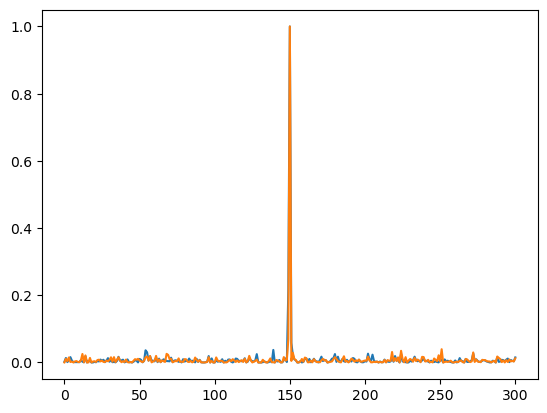

In [92]:
plt.plot(a1g[0])
plt.plot(a1g[10])

In [93]:
analyzer_gradient = innvestigate.create_analyzer("lrp.z", best_model)
a1g = np.zeros((samples, nx+1), dtype = np.float64)
for sample in range(samples):
    a1g[sample] = analyzer_gradient.analyze(M_samples[sample][np.newaxis,:])
    a1g[sample] /= np.max(np.abs(a1g[sample]))
    

2023-06-27 13:00:43.803218: W tensorflow/c/c_api.cc:291] Operation '{name:'kernel_4/Assign' id:657 op device:{requested: '', assigned: ''} def:{{{node kernel_4/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_4, kernel_4/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 13:00:43.839830: W tensorflow/c/c_api.cc:291] Operation '{name:'gradients_5/MaxNeuronSelection_1/Max_grad/range' id:686 op device:{requested: '', assigned: ''} def:{{{node gradients_5/MaxNeuronSelection_1/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection_1/Max"], _has_manual_control_dependencies=true](gradients_5/MaxNeuronSelection_1/Max_grad/range/start, gradients_5/MaxNeuronSelection_1/Max_grad/Size, gradients_5/MaxNeuronSele

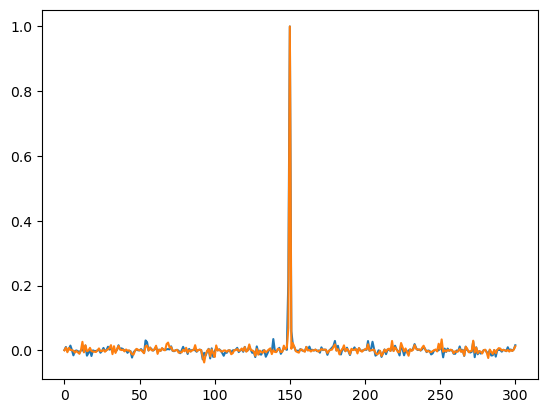

In [94]:
plt.plot(a1g[0])
plt.plot(a1g[10])

In [349]:
def regression_letzgus(model, input_, y_ref, step_width=0.00005, max_it=10e4, method = "flood"):
    
    ### Finding a_ref for a given y_ref
    
    if method == "flood":
    
        #         a = model.layers[-1].get_weights()[0]
        
        model_part = Model(inputs=model.input,
                          outputs=model.layers[-2].output)
        a_ref = model_part.predict(input_)[0,:]
        #         print(np.dot(a_ref, model.layers[-1].get_weights()[0][:,0]))
        a_ref = a_ref[:, np.newaxis]
        update = np.ones(a_ref.shape) * step_width
        
        y = model.predict(input_)
        #         print(f'y = {y} / y_ref = {y_ref}')
        
        #         frozen_bias = model.layers[-1].get_weights()[1]

        #         if frozen_bias != 0:
        #             raise ValueError("Forcing last layer bias to be 0, but it isn't 0!")
        
        counter = 0
        
        if y > y_ref:
            
            while y >= y_ref:
                a_ref = np.maximum(np.zeros(a_ref.shape),a_ref-update)
                
                #                 model.layers[-1].set_weights([a_ref])
                #                 model.layers[-1].set_weights([a_ref,
                #                                               np.zeros((1,))])
                y = np.dot(model.layers[-1].get_weights()[0][:,0], a_ref[:,0])
                counter +=1 
                print(f'iteration {counter} - y: {y}', end='\r')
                if counter > max_it:
                    print(f'! reference value {y_ref} was not reached within {round(max_it)} iterations!')
                    break
        else:
            
            while y <= y_ref:
                
                a_ref = np.maximum(np.zeros(a.shape),a_ref+update)
                model.layers[-1].set_weights([a_ref])
                #                 model.layers[-1].set_weights([a_ref,
                #                                               np.zeros((1,))])
                y = np.dot(model.layers[-1].get_weights()[0][:,0], a_ref[:,0])
                counter +=1 
                print(f'iteration {counter} - y: {y}', end='\r')
                if counter > max_it:
                    print(f'! reference value {y_ref} was not reached within {round(max_it)} iterations!')
                    break
    else: 
        
        raise ValueError("The only methods available are : flood")
        
    return a_ref

In [350]:
model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
a_ref = regression_letzgus(model_reg, M_samples[np.newaxis, 0], 0.002)
a_ref

2023-06-27 17:14:14.731238: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_83/Relu' id:18301 op device:{requested: '', assigned: ''} def:{{{node dense_83/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_83/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 17:14:15.260632: W tensorflow/c/c_api.cc:291] Operation '{name:'total_189/Assign' id:18677 op device:{requested: '', assigned: ''} def:{{{node total_189/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_189, total_189/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 17:14:15.87

array([[0.        ],
       [0.00319594],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

In [352]:
model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
a_ref = regression_letzgus(model_reg, M_samples[np.newaxis, 0], 0.09)
a_ref

2023-06-27 17:14:36.194187: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_83/Relu' id:18301 op device:{requested: '', assigned: ''} def:{{{node dense_83/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_83/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 17:14:36.782981: W tensorflow/c/c_api.cc:291] Operation '{name:'total_191/Assign' id:18775 op device:{requested: '', assigned: ''} def:{{{node total_191/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_191, total_191/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 17:14:37.51

array([[0.07825   ],
       [0.12429594],
       [0.10448518],
       [0.11111626],
       [0.07825   ],
       [0.07825   ],
       [0.07825   ],
       [0.12080371],
       [0.07825   ],
       [0.07825   ]])

In [353]:
def triplicated_model(best_model, a_ref):
    
    # get weights and biases
    W_in = best_model.layers[-2].get_weights()[0]
    W_out = best_model.layers[-1].get_weights()[0]
    bias_in = best_model.layers[-2].get_weights()[1]

    inputs = Input(shape=(nx+1,))

    # layer_dict = dict([(layer.name, layer) for layer in model.layers[:-2]])
    # weights = layer_dict['some_name'].get_weights()

    dense11 = Dense(10, activation='relu', name='dense11')
    dense12 = Dense(10, activation='relu', name='dense12')
    dense13 = Dense(10, activation='relu', name='dense13')
    dense21 = Dense(1, activation='linear', use_bias=False, name='dense21')
    dense22 = Dense(1, activation='linear', use_bias=False, name='dense22')
    dense23 = Dense(1, activation='linear', use_bias=False, name='dense23')

    x1 = dense11(inputs)
    x2 = dense12(inputs)
    x3 = dense13(inputs)

    x1 = dense21(x1)
    x2 = dense22(x2)
    x3 = dense23(x3)

    model = keras.Model(inputs=inputs, outputs=x1+x2+x3) 
    
    def getLayerIndexByName(model, layername):
        for idx, layer in enumerate(model.layers):
            if layer.name == layername:
                return idx
            
    model.layers[getLayerIndexByName(model, 'dense11')].set_weights([W_in, bias_in-a_ref[:,0]])
    model.layers[getLayerIndexByName(model, 'dense12')].set_weights([-W_in, -bias_in])                 
    model.layers[getLayerIndexByName(model, 'dense13')].set_weights([-W_in, -bias_in+a_ref[:,0]])
    
    model.layers[getLayerIndexByName(model, 'dense21')].set_weights([W_out])
    model.layers[getLayerIndexByName(model, 'dense22')].set_weights([W_out])
    model.layers[getLayerIndexByName(model, 'dense23')].set_weights([-W_out])
    
    model.compile(loss='mse', optimizer='adam',metrics=['mae'])
    
    return model

In [354]:
y_ref = 0.01

best_model = keras.Model(inputs=inputs, outputs=x) 
best_model.load_weights(mod_h5)
best_model.compile(loss='mse', optimizer='adam',metrics=['mae'])
a = best_model.layers[-1].get_weights()[0]

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
a_ref = regression_letzgus(model_reg, M_samples[np.newaxis, 0], y_ref)

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
tri_model = triplicated_model(model_reg, a_ref)
y_reg = tri_model.predict(M_samples[np.newaxis, 0])
y = best_model.predict(M_samples[np.newaxis, 0])

y,y_reg,y_ref 

2023-06-27 17:15:07.539710: W tensorflow/c/c_api.cc:291] Operation '{name:'count_192/Assign' id:18829 op device:{requested: '', assigned: ''} def:{{{node count_192/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_192, count_192/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 17:15:08.100668: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_83/Relu' id:18301 op device:{requested: '', assigned: ''} def:{{{node dense_83/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_83/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 17:15:08.56

2023-06-27 17:15:10.674774: W tensorflow/c/c_api.cc:291] Operation '{name:'count_194/Assign' id:18925 op device:{requested: '', assigned: ''} def:{{{node count_194/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_194, count_194/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-27 17:15:11.822063: W tensorflow/c/c_api.cc:291] Operation '{name:'dense13_45/bias/Assign' id:19029 op device:{requested: '', assigned: ''} def:{{{node dense13_45/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense13_45/bias, dense13_45/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Ei

(array([[0.06388438]], dtype=float32),
 array([[0.05388771]], dtype=float32),
 0.01)

NotImplementedError: 

In [ ]:
def triplicated_model(best_model, a_ref):
    
    # get weights and biases
    W_in = best_model.layers[-2].get_weights()[0]
    W_out = best_model.layers[-1].get_weights()[0]
    bias_in = best_model.layers[-2].get_weights()[1]

    inputs = Input(shape=(nx+1,))

    # layer_dict = dict([(layer.name, layer) for layer in model.layers[:-2]])
    # weights = layer_dict['some_name'].get_weights()

    dense11 = Dense(10, activation='relu', name='dense11')
    dense12 = Dense(10, activation='relu', name='dense12')
    dense13 = Dense(10, activation='relu', name='dense13')
    dense21 = Dense(1, activation='linear', use_bias=False, name='dense21')
    dense22 = Dense(1, activation='linear', use_bias=False, name='dense22')
    dense23 = Dense(1, activation='linear', use_bias=False, name='dense23')

    x1 = dense11(inputs)
    x2 = dense12(inputs)
    x3 = dense13(inputs)

    x1 = dense21(x1)
    x2 = dense22(x2)
    x3 = dense23(x3)

    model = keras.Model(inputs=inputs, outputs=x1+x2+x3) 
    
    def getLayerIndexByName(model, layername):
        for idx, layer in enumerate(model.layers):
            if layer.name == layername:
                return idx
            
    model.layers[getLayerIndexByName(model, 'dense11')].set_weights([W_in, bias_in-a_ref[:,0]])
    model.layers[getLayerIndexByName(model, 'dense12')].set_weights([-W_in, -bias_in])                 
    model.layers[getLayerIndexByName(model, 'dense13')].set_weights([-W_in, -bias_in+a_ref[:,0]])
    
    model.layers[getLayerIndexByName(model, 'dense21')].set_weights([W_out])
    model.layers[getLayerIndexByName(model, 'dense22')].set_weights([W_out])
    model.layers[getLayerIndexByName(model, 'dense23')].set_weights([-W_out])
    
    model.compile(loss='mse', optimizer='adam',metrics=['mae'])
    
    return model